(demo_notebooks:measurement:intensity_on_vectors)=

# Measureing intensity on vectors and surfaces

Often, we want to measure the intensity of a signal on a vector or surface. This can be done using the measure_intensity_on_vectors() function. This function takes a vector or surface as input and returns the intensity of the signal on the vector or surface.

In [9]:
from napari_stress import vectors, sample_data, measurements, frame_by_frame
from skimage import transform, filters, measure
import napari
import vedo
import numpy as np

In [18]:
viewer = napari.Viewer(ndisplay=3)

Assistant skips harvesting pyclesperanto as it's not installed.
Assistant skips harvesting pyclesperanto_prototype as it's not installed.


## Segmentation of sample data

Before proceeding, we need to quickl segment the data. To do this in an efficient manner, we use the `frame_by_frame` functionality of the [napari-timelapse-processor](https://github.com/jo-mueller/napari-timelapse-processor):

In [19]:
droplet = sample_data.get_droplet_4d()[0][0]

In [20]:
def rescale(data: "napari.types.ImageData", scale_x: float = 1, scale_y: float = 1, scale_z: float = 1) -> "napari.types.ImageData":
    return transform.rescale(data, (scale_z, scale_y, scale_x), anti_aliasing=True)

def threshold_otsu(data: "napari.types.ImageData") -> "napari.types.LabelsData":
    return data > filters.threshold_otsu(data)

In [21]:
droplet_rescaled = frame_by_frame(rescale)(droplet, scale_x=1, scale_y=1, scale_z=2)
droplet_binary = frame_by_frame(threshold_otsu)(droplet_rescaled)

## Create surface

To create a surface from the rescaled and binarized droplet data, we use [napari-process-points-and-surfaces](https://www.napari-hub.org/plugins/napari-process-points-and-surfaces), which provides the marching-cubes algorithm to create a surface from a binary image.

In [22]:
def marching_cubes(data: "napari.types.ImageData", label_to_convert: int = 1) -> "napari.types.SurfaceData":
    vertices, faces, _, _ = measure.marching_cubes(data == label_to_convert)
    surface = (vertices, np.asarray(faces))
    return surface

def smooth_surface(surface: "napari.types.SurfaceData", n_iterations: float = 15) -> "napari.types.SurfaceData":
    surface_vedo = vedo.Mesh((surface[0].astype(float), np.asarray(surface[1])))
    surface_vedo.smooth(niter=n_iterations)

    return (surface_vedo.vertices, np.asarray(surface_vedo.cells))

In [27]:
surface = frame_by_frame(marching_cubes)(droplet_binary, 1)
surface_smooth = frame_by_frame(smooth_surface)(surface, 50)

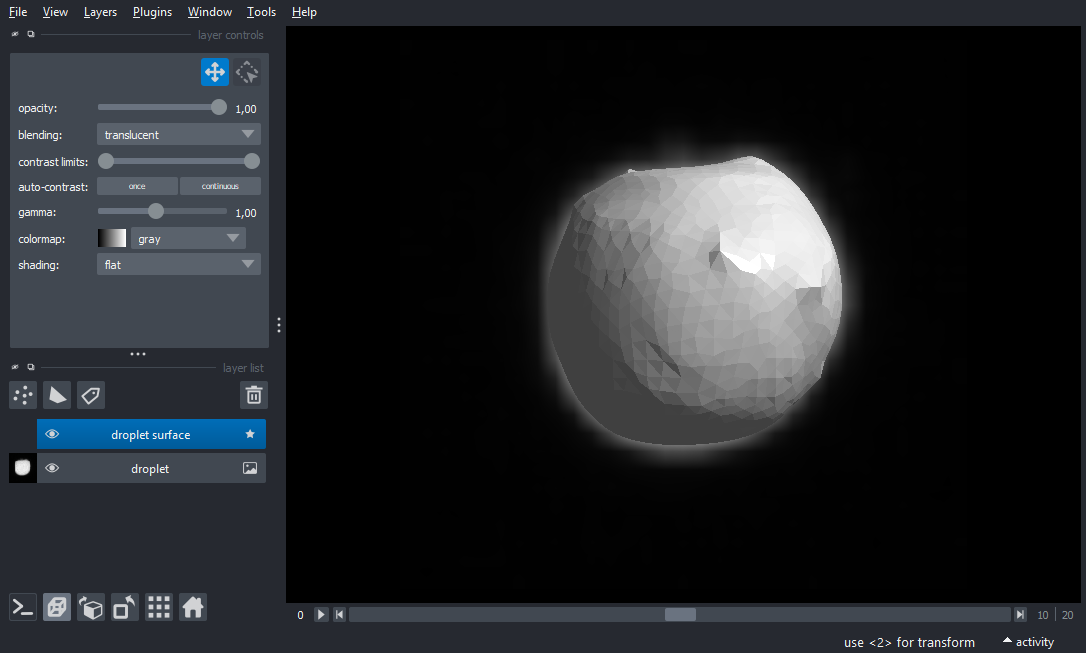

In [53]:
viewer.layers.clear()
viewer.add_image(droplet_rescaled, name="droplet")
viewer.add_surface(surface_smooth, name="droplet surface")
napari.utils.nbscreenshot(viewer)

## Measureing intensity

We now calculate the surface normals of the surface and use them to measure the intensity of the signal on the surface. To be able to measure intensity in a rregion around the surface, we can pass the `length_multiplier` value to the function, which will create a vector with the length of the surface normal multiplied by the `length_multiplier` value. The intensity of the signal on the vector is then measured.

Moreover, the `center` parameter determines whether the vector is centered on the surface or not. If `center` is set to `True`, the vector is centered on the surface. If `center` is set to `False`, the vector can point outwards or inwards, depending on the sign of the `length_multiplier` parameter.

In [54]:
normals = vectors.normal_vectors_on_surface(surface_smooth, length_multiplier=-2.5, center=True)
vectors_LDtuple = measurements.intensity._sample_intensity_along_vector(normals, droplet_rescaled)

layer = napari.layers.Vectors(vectors_LDtuple[0], features=vectors_LDtuple[1]['features'], edge_color="intensity_mean", edge_width=0.25, edge_colormap='inferno', vector_style='arrow')
vector_layer = viewer.add_layer(layer)

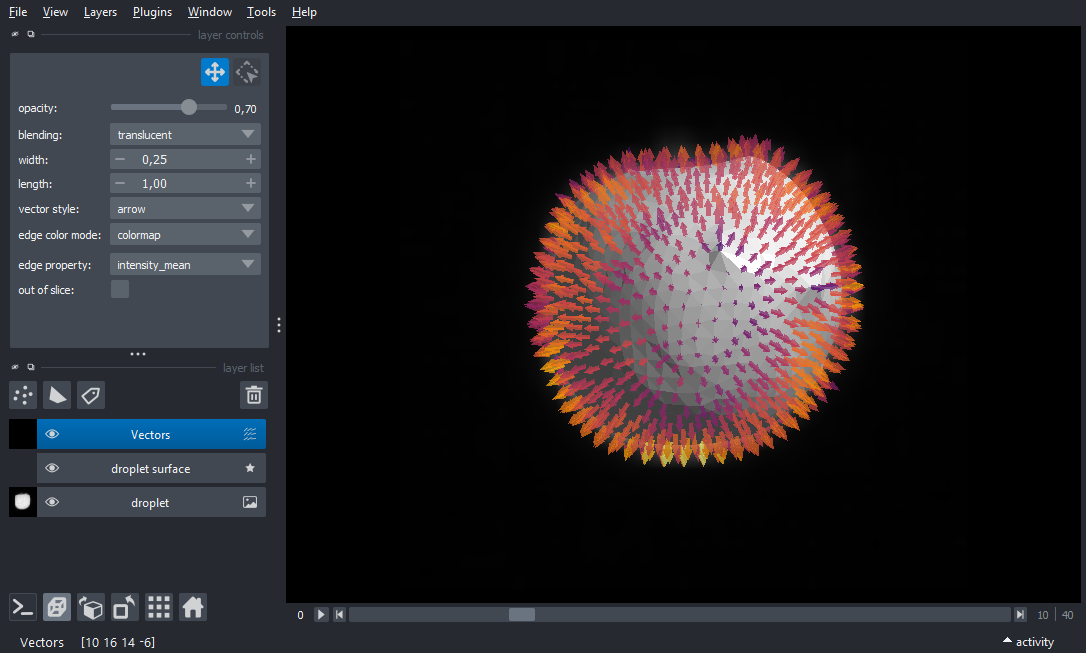

In [55]:
napari.utils.nbscreenshot(viewer)

## Projecting vector measurements on surface

Lastly, we can project the vector measurements on the surface. The measurements are stored in a `features` table that is attached to the last added vectors layer:

In [56]:
viewer.layers[-1].features.head()

,step_0,step_1,intensity_mean,intensity_std,intensity_max,intensity_min,frame
0,0.548708,0.332668,0.440688,0.152763,0.548708,0.332668,0
1,0.528460,0.310654,0.419557,0.154012,0.528460,0.310654,0
2,0.527439,0.311754,0.419597,0.152513,0.527439,0.311754,0
3,0.526494,0.298171,0.412333,0.161448,0.526494,0.298171,0
4,0.565903,0.347523,0.456713,0.154418,0.565903,0.347523,0


To colour the surface according to either of these measurements, we can simply do so by the following lines of code: 

In [57]:
values_to_visualize = viewer.layers[-1].features['intensity_max'].values
new_surface_tuple = (surface_smooth[0], surface_smooth[1], values_to_visualize)

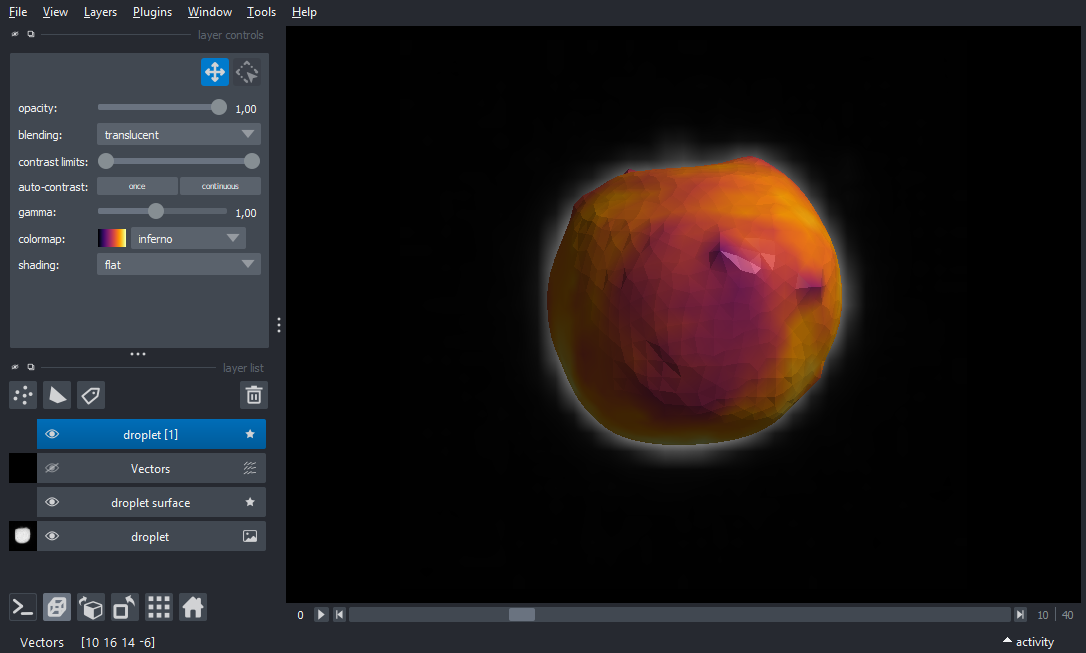

In [58]:
vector_layer.visible = False
viewer.add_surface(new_surface_tuple, name="droplet", colormap='inferno')
napari.utils.nbscreenshot(viewer)